# Quaternion Rotation with Spherical Cap Visualization

This notebook demonstrates how to use quaternions for 3D rotations and visualize the results with a spherical cap. We'll use `jax.scipy.spatial.transform.Rotation` to create initial rotations and convert them to FastQuat quaternions.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.spatial.transform import Rotation

from fastquat import Quaternion

# Configure matplotlib for better rendering
plt.rcParams['figure.dpi'] = 100

## Step 1: Initial Rotation Around X-axis Using JAX Scipy

We'll create a 30° rotation around the X-axis using `jax.scipy.spatial.transform.Rotation.from_euler` and convert it to a FastQuat quaternion.

In [2]:
# Create initial rotation using scipy's Rotation around X-axis
rotation_main = Rotation.from_euler('x', 30.0, degrees=True).as_matrix()

# Convert to FastQuat quaternion
q_main = Quaternion.from_rotation_matrix(rotation_main)

print(f'Main rotation quaternion (30° around X): {q_main}')
print(f'Main quaternion norm: {q_main.norm():.6f}')
print(f'Rotation matrix shape: {rotation_main.shape}')

k_vector = jnp.array([0, 0, 1])
rotated_k_vector = q_main.rotate_vector(k_vector)

Main rotation quaternion (30° around X): 0.9659258127212524 + 0.258819043636322i + 0.0j + 0.0k
Main quaternion norm: 1.000000
Rotation matrix shape: (3, 3)


## Display

Create a 3D visualization showing the unit sphere, the original and rotated k vectors.

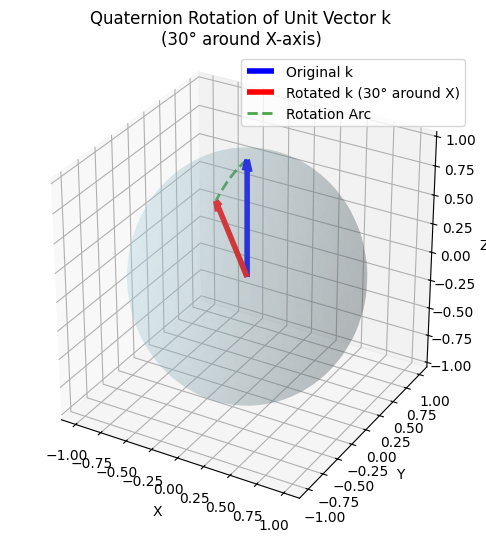

In [3]:
def create_visualization(original_vector, rotated_vector):
    """Create comprehensive visualization of quaternion rotation and spherical cap."""

    fig = plt.figure(figsize=(15, 6))

    # Generate unit sphere for visualization
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))

    # Left plot: Vector rotation demonstration
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(sphere_x, sphere_y, sphere_z, alpha=0.2, color='lightblue')

    # Original k vector (blue)
    ax.quiver(
        0,
        0,
        0,
        *original_vector,
        color='blue',
        arrow_length_ratio=0.1,
        linewidth=4,
        label='Original k',
    )

    # Rotated k vector (red)
    ax.quiver(
        0,
        0,
        0,
        *rotated_vector,
        color='red',
        arrow_length_ratio=0.1,
        linewidth=4,
        label='Rotated k (30° around X)',
    )

    # Show rotation arc
    theta_arc = np.linspace(0, np.pi / 6, 20)  # 20 degrees in radians
    arc_x = np.zeros_like(theta_arc)
    arc_y = -np.sin(theta_arc)
    arc_z = np.cos(theta_arc)
    ax.plot(arc_x, arc_y, arc_z, 'g--', linewidth=2, alpha=0.7, label='Rotation Arc')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Quaternion Rotation of Unit Vector k\n(30° around X-axis)')
    ax.legend()
    ax.set_box_aspect([1, 1, 1])
    #    plt.tight_layout()
    # plt.savefig('spherical_cap_visualization.png', dpi=150, bbox_inches='tight')
    # plt.show()
    return fig


fig = create_visualization(k_vector, rotated_k_vector)

## Step 2: Create Small Rotation for Spherical Cap

We'll create a 1° rotation around the Z-axis to generate the spherical cap through quaternion multiplication and we'll create the spherical cap by repeatedly applying the small rotation to demonstrate quaternion multiplication.

In [12]:
# Create small rotation for spherical cap of 1 degree rotation around the Z-axis
small_rotation = Rotation.from_euler('z', 1, degrees=True)
small_matrix = small_rotation.as_matrix()
q_small = Quaternion.from_rotation_matrix(small_matrix)

print(f'Small rotation quaternion (1° around Z): {q_small}')
print(f'Small quaternion norm: {q_small.norm():.6f}')


@jax.jit
def apply_small_rotation(quaternion):
    quaternion = q_small * quaternion
    vector = quaternion.rotate_vector(k_vector)
    return quaternion, vector


def create_spherical_cap():
    """Create a spherical cap using quaternion multiplication."""

    # Create cap by applying small rotations iteratively
    points = []

    # Generate 360 points by repeatedly applying 1° rotation
    q_accumulated = q_main
    for i in range(360):
        q_accumulated, rotated_point = apply_small_rotation(q_accumulated)
        points.append(rotated_point)
    return jnp.array(points)


# Generate the spherical cap
cap_points = create_spherical_cap()

print(f'Original k vector: {k_vector}')
print(f'Rotated k vector: {rotated_k_vector}')
print(f'Generated {len(cap_points)} points for spherical cap')
print(f'Cap points shape: {cap_points.shape}')

Small rotation quaternion (1° around Z): 0.9999619126319885 + 0.0i + 0.0j + 0.008726535364985466k
Small quaternion norm: 1.000000
Original k vector: [0 0 1]
Rotated k vector: [ 0.         -0.50000006  0.86602545]
Generated 360 points for spherical cap
Cap points shape: (360, 3)


## Display

Create a 3D visualization showing the unit sphere, the original and rotated k vectors, and the spherical cap.

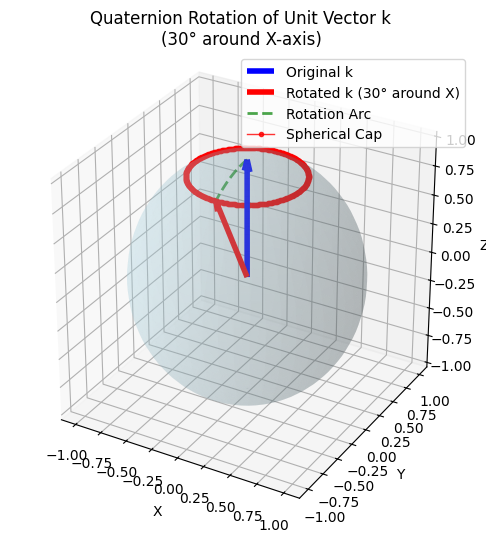

In [13]:
fig = create_visualization(k_vector, rotated_k_vector)
ax = plt.gca()

# Plot the spherical cap as connected points
ax.plot(*cap_points.T, 'ro-', markersize=3, linewidth=1, alpha=0.8, label='Spherical Cap')
ax.legend()
ax.set_box_aspect([1, 1, 1])

## Mathematical Background

This example demonstrates several key concepts:

### Quaternion Representation
The rotation of a vector **v** by a unit quaternion **q** is given by:
$$\mathbf{v}' = q \mathbf{v} q^{-1}$$

### Quaternion Multiplication
Quaternion multiplication represents composition of rotations:
$$q_3 = q_2 \cdot q_1$$
means "first apply rotation $q_1$, then apply rotation $q_2$".

### Spherical Cap Generation
By iteratively applying small rotations:
$$q_n = q_{\text{small}} \cdot q_{n-1}$$

we generate points that form a spherical cap around the main rotation axis.

## Key Insights

1. **Conversion Fidelity**: Converting from Euler angles → rotation matrix → quaternion preserves the rotation exactly
2. **Quaternion Multiplication**: Represents smooth composition of rotations
3. **Normalization**: All operations preserve quaternion normalization automatically
4. **Geometric Consistency**: The spherical cap forms a perfect circle on the unit sphere

This makes FastQuat ideal for applications requiring precise 3D rotations, such as:
- Robotics and mechanical engineering
- Computer graphics and animation
- Aerospace and navigation systems
- Scientific visualization